In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy.misc

# Building necessary functions

In [2]:
#construct vector V of shape (2*N,1) from vector v of shape (2,N)
def V_construct(v):
    N=v.shape[1]
    V=np.zeros((2*N,1))
    for i in range(2*N):
        if(i%2==0):
            V[i:i+2,0]=v[:,int(np.floor(i/2))]
    return V

def A_construct_affine(u):
    N=u.shape[1]
    U=np.concatenate((u,np.ones((1,N))), axis=0)
    
    #Construct Matrix A of shape (2*N,6)
    A=np.zeros((2*N,6))
    for i in range(8):
        if(i%2==0):
            A[i,0:3]= U[:,int(i/2)]
        else:
            A[i,3:6]= U[:,int(np.floor(i/2))]
    return A

def A_construct_homography(u,v):
    N=u.shape[1]
    A_affine=A_construct_affine(u)
    A_rest=np.zeros((2*N,2))
    
    for i in range(2*N):
        if (i%2==0):
            j=int(np.floor(i/2))
            A_rest[i,0]=-u[0,j]*v[0,j]
            A_rest[i,1]=-u[1,j]*v[0,j]
            A_rest[i+1,0]=-u[0,j]*v[1,j]
            A_rest[i+1,1]=-u[1,j]*v[1,j]
    
    A_merged=np.concatenate((A_affine, A_rest), axis=1)
    return A_merged
            
    
def affine_solve(u,v):
    N=u.shape[1]
    U=np.concatenate((u,np.ones((1,N))), axis=0)
    
    #construction of matrix A
    A=A_construct_affine(u)
    
    #constructon of vector V         
    V=V_construct(v)
    
    #Find h*
    h=np.zeros((2*N,1))
    #h=np.linalg.inv(A.T.dot(A)).dot(A.T).dot(V)
    h=np.linalg.solve(A.T.dot(A), A.T.dot(V))
    
    #reconstruction of matrix H* from vector h*
    H_affine=np.zeros((3,3))
    H_affine[0,:]=h[0:3,0]
    H_affine[1,:]=h[3:6,0]
    H_affine[2,:]=np.array([0,0,1])
    
    return H_affine
    
def homography_solve(u,v):
    N=u.shape[1]
    
    #construction of matrix A
    A=A_construct_homography(u,v)
    
    #constructon of vector V         
    V=V_construct(v)
    
    #Find h*
    h=np.zeros((2*N,1))
    #h=np.linalg.inv(A).dot(V)
    h=np.linalg.solve(A, V)
    
    
    #reconstruction of matrix H* from vector h*
    H_homography=np.zeros((3,3))
    H_homography[0,:]=h[0:3,0]
    H_homography[1,:]=h[3:6,0]
    H_homography[2,0:2]=h[6:8,0]
    H_homography[2,2]=1
    
    return H_homography
                            

In [3]:
u=np.array([[1,2],[3,4],[5,6],[7,8]])
u=u.T
#============ test of the functions ================================
print('========== test construction matrix A affine case=============')
A1=A_construct_affine(u)
print('initial vector:\n',u)
print('Matrix A_affine :\n', A1)

print('========== test construction matrix A homography case=============')
A2=A_construct_homography(u,u)
print('initial vectors: \n',u,u)
print('Matrix A_homography :\n', A2)


print('========== test affine_solve =============')
H_affine=affine_solve(u,u)
print(H_affine)

print('========== test homography_solve =============')
H_homography=homography_solve(u,u)
print(H_homography)

========== test construction matrix A affine case=============
initial vector:
 [[1 3 5 7]
 [2 4 6 8]]
Matrix A_affine :
 [[ 1.  2.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  2.  1.]
 [ 3.  4.  1.  0.  0.  0.]
 [ 0.  0.  0.  3.  4.  1.]
 [ 5.  6.  1.  0.  0.  0.]
 [ 0.  0.  0.  5.  6.  1.]
 [ 7.  8.  1.  0.  0.  0.]
 [ 0.  0.  0.  7.  8.  1.]]
========== test construction matrix A homography case=============
initial vectors: 
 [[1 3 5 7]
 [2 4 6 8]] [[1 3 5 7]
 [2 4 6 8]]
Matrix A_homography :
 [[  1.   2.   1.   0.   0.   0.  -1.  -2.]
 [  0.   0.   0.   1.   2.   1.  -2.  -4.]
 [  3.   4.   1.   0.   0.   0.  -9. -12.]
 [  0.   0.   0.   3.   4.   1. -12. -16.]
 [  5.   6.   1.   0.   0.   0. -25. -30.]
 [  0.   0.   0.   5.   6.   1. -30. -36.]
 [  7.   8.   1.   0.   0.   0. -49. -56.]
 [  0.   0.   0.   7.   8.   1. -56. -64.]]
========== test affine_solve =============
[[ 1.          0.         -0.        ]
 [-0.08130081  1.08130081 -0.08130081]
 [ 0.          0.          1.        ]]


In [4]:
#find vector v from u and H
def homography_transform(u,H):
    N=u.shape[1]
    U=np.concatenate((u,np.ones((1,N))), axis=0)
    v_tempo=H.dot(U)
    
    for i in range(N):
        v_tempo[:,i]=v_tempo[:,i]/v_tempo[2,i]
    
    
    return v_tempo[0:2,:]
    

In [5]:
print('============ Test function homography_transform ===========')
u=np.array([[1,2],[4,7],[8,1],[2,65]]).T

u_initial=np.array([[13,2],[21,7],[-4,71],[2,-65]]).T

H_homography=homography_solve(u,u)
v=homography_transform(u_initial,H_homography)

print('Since we used the homographie transformation that transforms u into u (himself)', 
      ', we should have the same initial vector and end vector')
print('vector initial:\n', u_initial,'\n final vector v:\n',v)


============ Test function homography_transform ===========
Since we used the homographie transformation that transforms u into u (himself) , we should have the same initial vector and end vector
vector initial:
 [[ 13  21  -4   2]
 [  2   7  71 -65]] 
 final vector v:
 [[ 13.  21.  -4.   2.]
 [  2.   7.  71. -65.]]


# Transform images

In [6]:
def change_image(u,v,image_me, image_to_change, transfo):
    
    img_1=image_me.copy()
    img_2=image_to_change.copy()
    
    N0=image_to_change.shape[0]
    N1=image_to_change.shape[1]
    if(transfo=='homography'):
        H=homography_solve(u,v)
    if(transfo=='affine'):
        H=affine_solve(u,v)
    for i in range(0,img_1.shape[0]):
        for j in range(0,img_1.shape[1]):
            
            u_pixel=np.array([i,j])
            U=np.concatenate((u_pixel,np.ones(1)), axis=0)
            v_pixel=H.dot(U)
            v_pixel=v_pixel/v_pixel[2]
            if (v_pixel[0]<N0):
                if(v_pixel[1]<N1):

                    img_2[int(v_pixel[0]),int(v_pixel[1]),:]=img_1[i,j,:]
    return img_2

 ============== INITIAL IMAGES ===============


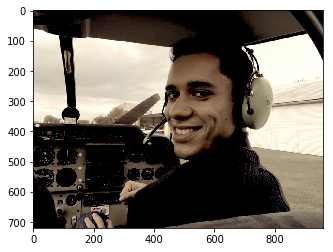

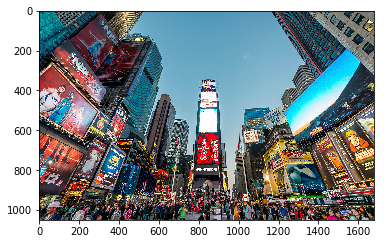

In [7]:
print(' ============== INITIAL IMAGES ===============')
img1=mpimg.imread('images/image_myself.jpg')
imgplot = plt.imshow(img1)
plt.show()

img2=mpimg.imread('images/times_square.jpg')
imgplot = plt.imshow(img2)
plt.show()


============== Test image change  with homography==========


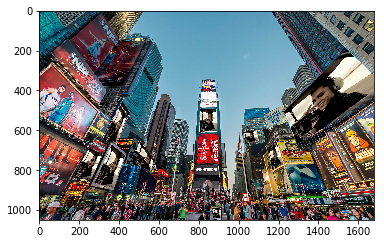

In [8]:
print('============== Test image change  with homography==========')
#shape of image_me= (720,960,3)
image_me=mpimg.imread('images/image_myself.jpg')
#shape of image_to_change =(1050,1680,3)
image_to_change=mpimg.imread('images/times_square.jpg')

######################## Vectors to transform #########
u=np.array([[0,0],[0,960],[ 720,960],[720,0]]).T

v1=v=np.array([[509, 1230],[196,1543],[392,1750],[669,1297]]).T
v2=np.array([[497,810],[498,889],[603,891],[609,805]]).T
v3=np.array([[610,1025],[599,1086],[655,1099],[664,1035]]).T
v4=np.array([[655,505],[748,577],[814,561],[756,469]]).T
v5=np.array([[704,1149],[664,1192],[771,1225],[796,1173]]).T
v6=np.array([[992,876],[993,911],[1042,914],[1042,874]]).T
v7=np.array([[677,365],[726,431],[887,369],[865,280]]).T
v8=np.array([[479,406],[531,442],[674,384],[646,325]]).T
v9=np.array([[690,252],[720,319],[845,262],[828,177]]).T

#Add my face everywhere
img1=change_image(u,v1,image_me, image_to_change,'homography')
img2=change_image(u,v2,image_me, img1,'homography')
img3=change_image(u,v3,image_me, img2,'homography')
img4=change_image(u,v4,image_me, img3,'homography')
img5=change_image(u,v5,image_me, img4,'homography')
img6=change_image(u,v6,image_me, img5,'homography')
img7=change_image(u,v7,image_me, img6,'homography')
img8=change_image(u,v8,image_me, img7,'homography')
img9=change_image(u,v9,image_me, img8,'homography')

imgplot = plt.imshow(img9)
plt.show()

scipy.misc.imsave('photo_change_homography.jpg', img9)
# im = Image.open('photo_finale.jpg')
# im.show()



============== Test image change  with affine transformation ==========


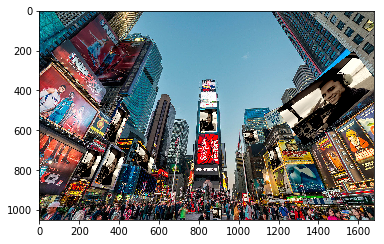

In [10]:

print('============== Test image change  with affine transformation ==========')
#shape of image_me= (720,960,3)
image_me=mpimg.imread('images/image_myself.jpg')
#shape of image_to_change =(1050,1680,3)
image_to_change=mpimg.imread('images/times_square.jpg')

######################## Vectors to transform #########
u=np.array([[0,0],[0,960],[ 720,960],[720,0]]).T

v1=v=np.array([[509, 1230],[196,1543],[392,1750],[669,1297]]).T
v2=np.array([[497,810],[498,889],[603,891],[609,805]]).T
v3=np.array([[610,1025],[599,1086],[655,1099],[664,1035]]).T
v4=np.array([[655,505],[748,577],[814,561],[756,469]]).T
v5=np.array([[704,1149],[664,1192],[771,1225],[796,1173]]).T
v6=np.array([[992,876],[993,911],[1042,914],[1042,874]]).T
v7=np.array([[677,365],[726,431],[887,369],[865,280]]).T
v8=np.array([[479,406],[531,442],[674,384],[646,325]]).T
v9=np.array([[690,252],[720,319],[845,262],[828,177]]).T

#Add my face everywhere
img1=change_image(u,v1,image_me, image_to_change,'affine')
img2=change_image(u,v2,image_me, img1,'affine')
img3=change_image(u,v3,image_me, img2,'affine')
img4=change_image(u,v4,image_me, img3,'affine')
img5=change_image(u,v5,image_me, img4,'affine')
img6=change_image(u,v6,image_me, img5,'affine')
img7=change_image(u,v7,image_me, img6,'affine')
img8=change_image(u,v8,image_me, img7,'affine')
img9=change_image(u,v9,image_me, img8,'affine')

imgplot = plt.imshow(img9)
plt.show()

scipy.misc.imsave('photo_change_affine.jpg', img9)
# im = Image.open('photo_finale.jpg')
# im.show()




============== Test image change  with homography==========


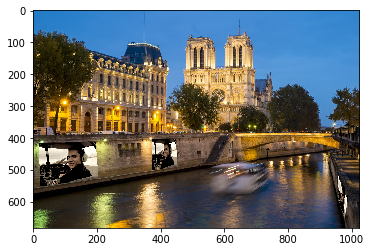

In [11]:
print('============== Test image change  with homography==========')
#shape of image_me
image_me=mpimg.imread('images/image_myself.jpg')
#shape of image_to_change 
image_to_change=mpimg.imread('images/seine_paris.jpg')

# # ######################## Vectors to transform #########
u=np.array([[0,0],[0,1024],[ 683,1024],[683,0]]).T

v1=np.array([[419, 20],[412,206],[520,214],[545,22]]).T
v2=np.array([[406, 373],[404,451],[485,457],[495,374]]).T
v3=np.array([[512, 956],[590,989],[656,978],[585,954]]).T


# # #Add my face everywhere
img1=change_image(u,v1,image_me, image_to_change,'homography')
img2=change_image(u,v2,image_me, img1,'homography')
img3=change_image(u,v3,image_me, img2,'homography')

imgplot = plt.imshow(img3)
plt.show()

scipy.misc.imsave('paris_myself.jpg', img3)






In [ ]:
# This function allow to get the pixel coordinate of points in a  given picture 

import wx

class MyCanvas(wx.ScrolledWindow):
    def __init__(self, parent, id = -1, size = wx.DefaultSize, filepath = None):
        wx.ScrolledWindow.__init__(self, parent, id, (0, 0), size=size, style=wx.SUNKEN_BORDER)

        self.image = wx.Image(filepath)
        self.w = self.image.GetWidth()
        self.h = self.image.GetHeight()
        self.bmp = wx.BitmapFromImage(self.image)

        self.SetVirtualSize((self.w, self.h))
        self.SetScrollRate(20,20)
        self.SetBackgroundColour(wx.Colour(0,0,0))

        self.buffer = wx.EmptyBitmap(self.w, self.h)
        dc = wx.BufferedDC(None, self.buffer)
        dc.SetBackground(wx.Brush(self.GetBackgroundColour()))
        dc.Clear()
        self.DoDrawing(dc)

        self.Bind(wx.EVT_PAINT, self.OnPaint)
        self.Bind(wx.EVT_LEFT_UP, self.OnClick)

    def OnClick(self, event):
        pos = self.CalcUnscrolledPosition(event.GetPosition())
        print ('%d, %d' %(pos.x, pos.y))

    def OnPaint(self, event):
        dc = wx.BufferedPaintDC(self, self.buffer, wx.BUFFER_VIRTUAL_AREA)

    def DoDrawing(self, dc):
        dc.DrawBitmap(self.bmp, 0, 0)

class MyFrame(wx.Frame): 
    def __init__(self, parent=None, id=-1, filepath = None): 
        wx.Frame.__init__(self, parent, id, title=filepath)
        self.canvas = MyCanvas(self, -1, filepath = filepath)

        self.canvas.SetMinSize((self.canvas.w, self.canvas.h))
        self.canvas.SetMaxSize((self.canvas.w, self.canvas.h))
        self.canvas.SetBackgroundColour(wx.Colour(0, 0, 0))
        vert = wx.BoxSizer(wx.VERTICAL)
        horz = wx.BoxSizer(wx.HORIZONTAL)
        vert.Add(horz,0, wx.EXPAND,0)
        vert.Add(self.canvas,1,wx.EXPAND,0)
        self.SetSizer(vert)
        vert.Fit(self)
        self.Layout()

In [ ]:
app = wx.App()
app.SetOutputWindowAttributes(title='stdout')  
wx.InitAllImageHandlers()

filepath = 'images/seine_paris.jpg'
if filepath:
    print( filepath)
    myframe = MyFrame(filepath=filepath)
    myframe.Center()
    myframe.Show()
    app.MainLoop()

In [ ]:
v1=np.array([[419, 20],[412,206],[527,214],[558,22]]).T
v2=np.array([[406, 373],[404,451],[492,457],[503,374]]).T
v3=np.array([[512, 956],[590,989],[656,978],[585,954]]).T

